In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import keras
import keras.utils
from keras import utils as np_utils

import tensorflow.keras.layers
import tensorflow as tf

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import concatenate
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense, Activation, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.optimizers import SGD
import cv2
import numpy as np

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
train_datagen_with_aug = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen_with_aug.flow_from_directory(
    r'/content/drive/My Drive/DR',
    target_size=(224, 224),
    batch_size=32,
    # color_mode='grayscale',
    class_mode='categorical',
    subset='training'
    ) # set as training data

validation_generator = train_datagen_with_aug.flow_from_directory(
    r'/content/drive/My Drive/DR', # same directory as training data
    target_size=(224, 224),
    batch_size=32,
    # color_mode='grayscale',
    class_mode='categorical',
    subset='validation'
    ) # set as validation data

input_img = Input(shape=(224, 224, 3))

Found 2248 images belonging to 5 classes.
Found 562 images belonging to 5 classes.


In [ ]:
import keras
from keras.layers import Dense, Flatten
from keras.optimizers import SGD, Adam

from keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.applications
from keras.applications import densenet

DENSENET_121 = Sequential()

densenet121_model = keras.applications.densenet.DenseNet121(
    include_top=False, weights='imagenet',
    input_shape=(224,224,3), pooling='max', classes=5
)

29084464/29084464 [==============================] - 0s 0us/step


In [12]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet121

# Load DenseNet-121 model without top layers
densenet121_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Create a Sequential model
DENSENET_121 = Sequential()

# Set layers in densenet121_model to non-trainable
for layer in densenet121_model.layers:
    layer.trainable = False

# Add layers to the model
DENSENET_121.add(densenet121_model)
DENSENET_121.add(Flatten())
DENSENET_121.add(Dropout(0.2))
DENSENET_121.add(Dense(1024, activation='relu'))
DENSENET_121.add(Dropout(0.2))
DENSENET_121.add(Dense(512, activation='relu'))
DENSENET_121.add(Dense(5, activation='softmax'))

# Summary of the model
DENSENET_121.summary()

# Compile the model
adam = Adam(learning_rate=0.001)
DENSENET_121.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy', precision_m, recall_m, f1_m])

# Assuming you have your ImageDataGenerators set up
# train_generator = ...
# validation_generator = ...

# Train the model
graph = DENSENET_121.fit(train_generator, epochs=25, validation_data=validation_generator)

# Save the model
DENSENET_121.save("/content/drive/My Drive/DENSENET_121(ADAM_0.001).h5")

# Print the results
print(graph.history)



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 flatten_1 (Flatten)         (None, 50176)             0         
                                                                 
 dropout_2 (Dropout)         (None, 50176)             0         
                                                                 
 dense_3 (Dense)             (None, 1024)              51381248  
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               524800    
                                                                 
 dense_5 (Dense)             (None, 5)                

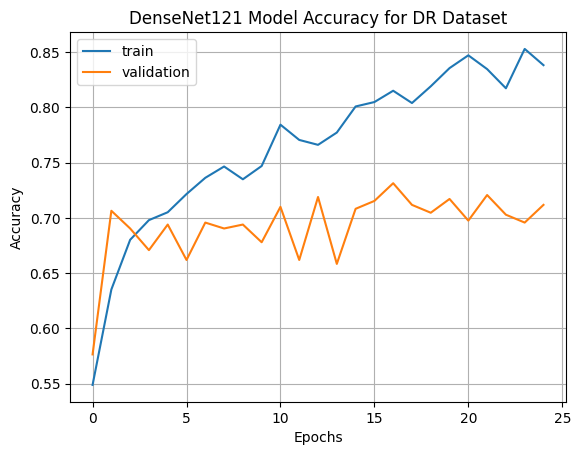

In [13]:

import matplotlib.pyplot as plt

fig1 = plt.gcf()

plt.plot(graph.history['accuracy'])
plt.plot(graph.history['val_accuracy'])

# plt.axis(ymin=0.4, ymax=1)
plt.grid()

plt.title('DenseNet121 Model Accuracy for DR Dataset')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train','validation'])

plt.show()

In [14]:
max_acc = max(graph.history['val_accuracy'])

print('The highest accuracy achieved using DenseNet121 model is',max_acc*100)

The highest accuracy achieved using DenseNet121 model is 73.13167452812195


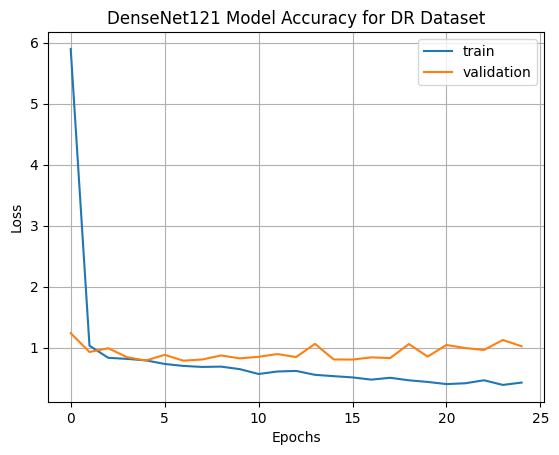

In [15]:
import matplotlib.pyplot as plt

fig1 = plt.gcf()

plt.plot(graph.history['loss'])
plt.plot(graph.history['val_loss'])

# plt.axis(ymin=0.4, ymax=1)
plt.grid()

plt.title('DenseNet121 Model Accuracy for DR Dataset')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train','validation'])

plt.show()